# **Melanoma Detection Using Custom CNN**

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# **1. Data Understanding and Reading**
We start by defining paths for training and testing datasets and understanding the structure of the data.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

# **2. Dataset Preparation**

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# **3. Data Visualization**
#### create a code to visualize one instance of all the nine classes present in the dataset

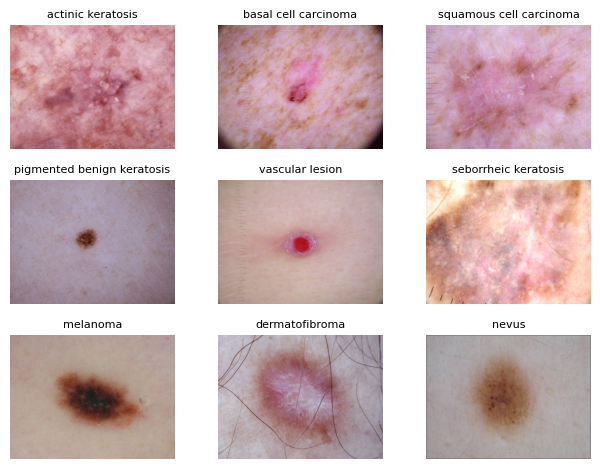

In [9]:
counter = 1
for c in data_dir_train.iterdir():
    files = list(c.iterdir())
    if files:
        im = Image.open(files[0])
        plt.subplot(3, 3, counter)
        plt.imshow(im)
        plt.title(str(c).split('/')[-1], fontsize=8)
        counter += 1
        plt.axis("off")

# Adjust the layout to avoid title overlap
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **4. CNN Model Building**
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

## **4.1 Creating Model-1**

In [11]:
num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.1945 - loss: 2.1363 - val_accuracy: 0.2886 - val_loss: 1.8820
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.3868 - loss: 1.7577 - val_accuracy: 0.3691 - val_loss: 1.7646
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4286 - loss: 1.5952 - val_accuracy: 0.4765 - val_loss: 1.4873
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4968 - loss: 1.4225 - val_accuracy: 0.5123 - val_loss: 1.4217
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5312 - loss: 1.2649 - val_accuracy: 0.5324 - val_loss: 1.4080
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5947 - loss: 1.1764 - val_accuracy: 0.5526 - val_loss: 1.3024
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6300 - loss: 1.0695 - val_accuracy: 0.5503 - val_loss: 1.3556
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6520 - loss: 1.0027 - val_accuracy: 0.5347 - 

### Visualizing training results

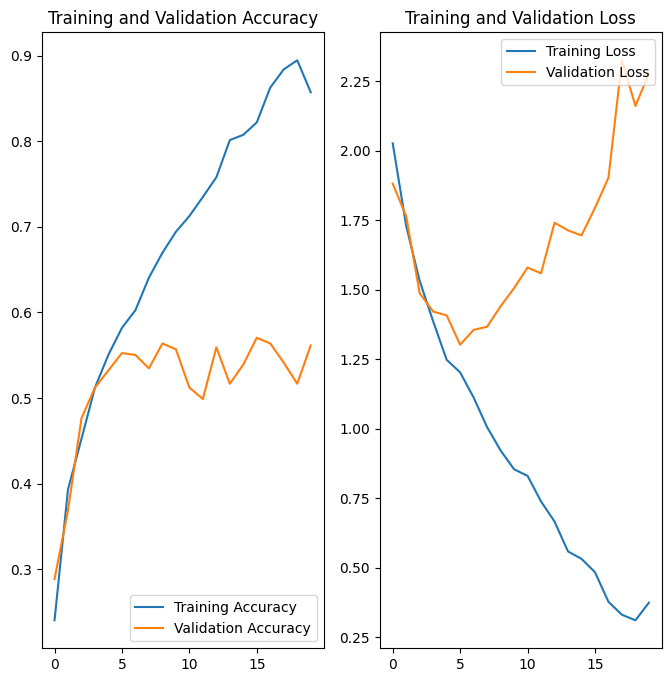

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, see if there is an evidence of model overfit or underfit

### **Findings and Data Augmentation**

## **Accuracy:**

**Training Accuracy:** The training accuracy steadily increases from the initial epochs, indicating that the model is learning from the training data.

**Validation Accuracy:** The validation accuracy increases initially but then plateaus and starts to decline. This suggests that the model is overfitting to the training data.

## **Loss:**

**Training Loss:**
The training loss decreases consistently throughout the training process, as expected.

**Validation Loss:** The validation loss decreases initially but then starts to increase significantly. This confirms the overfitting behavior observed in the accuracy plot.

**Recommendations for Improvement:**

**Early Stopping:** We Implement early stopping to avoid overfitting. This would halt training once the validation loss stops improving.

**Data Augmentation:** We use data augmentation to artificially increase the size of the training dataset. This improves generalization. We use more data augmentation to make the model more robust to different variations in input images.

**Example transformations:** rotation, flipping, zooming, and cropping.

In [16]:
# After we have analysed the model fit history for presence of underfit or overfit, we choose an appropriate data augumentation strategy.

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.RandomContrast(factor=0.2)  # Added contrast adjustment
])

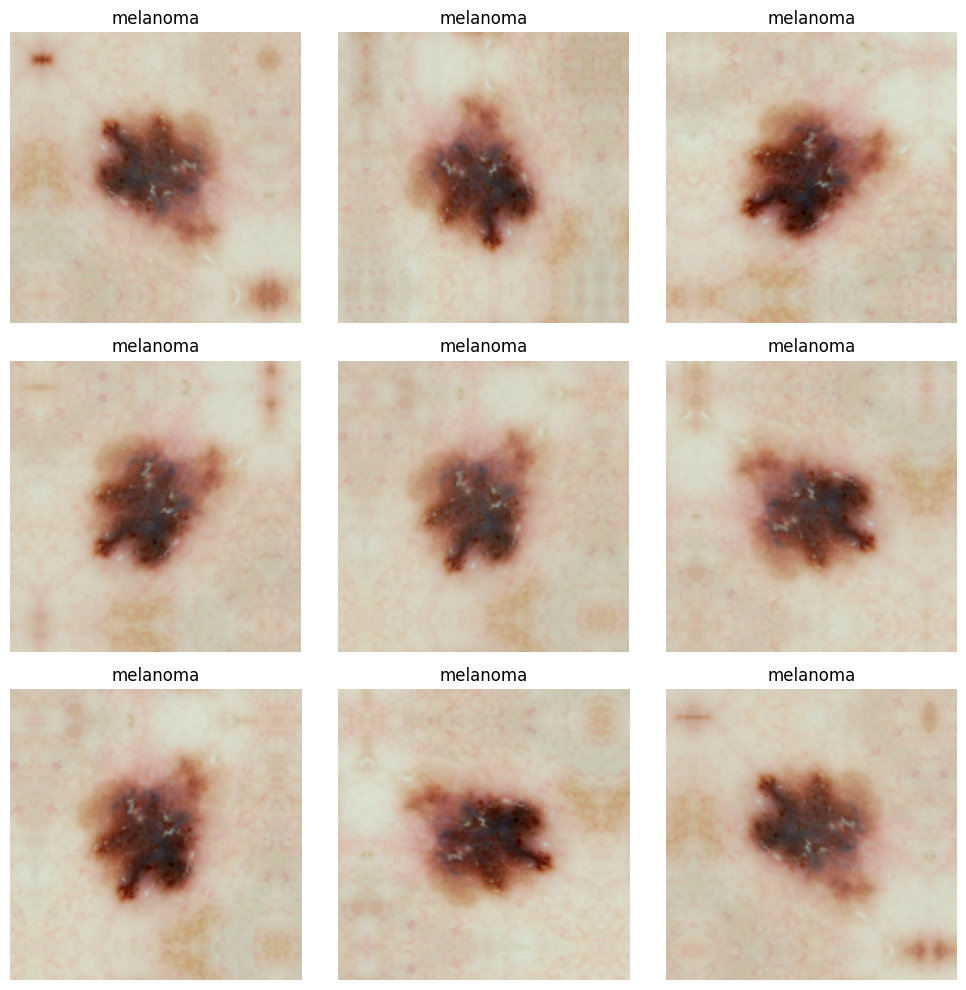

In [17]:
# Visualizing how your augmentation strategy works for one instance of training image.

for batch, labels in train_ds.take(1):
    im = batch[0]
    im = tf.reshape(im, (1, img_width, img_height, 3))

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(im)[0]
    img_to_show = augmented_image.numpy()
    img_to_show = img_to_show.astype("uint8")
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_to_show)
    plt.title(class_names[labels[0]])
    plt.axis("off")

plt.tight_layout()
plt.show()

## **4.2 Creating Model-2**
Creating Model-2 with Data Augmentation and Dropout to reduce Overfitting:-


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])


### Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Training the model

In [20]:
# Train our model-2 for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.1918 - loss: 2.2708 - val_accuracy: 0.3512 - val_loss: 1.9053
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3406 - loss: 1.8356 - val_accuracy: 0.4519 - val_loss: 1.6133
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4224 - loss: 1.6404 - val_accuracy: 0.4340 - val_loss: 1.5411
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4631 - loss: 1.5283 - val_accuracy: 0.3758 - val_loss: 1.7000
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4820 - loss: 1.4450 - val_accuracy: 0.5302 - val_loss: 1.3853
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5273 - loss: 1.3605 - val_accuracy: 0.5123 - val_loss: 1.3448
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5098 - loss: 1.3430 - val_accuracy: 0.4765 - val_loss: 1.4125
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5310 - loss: 1.3132 - val_accuracy: 0.5369 - v

### Visualizing the results

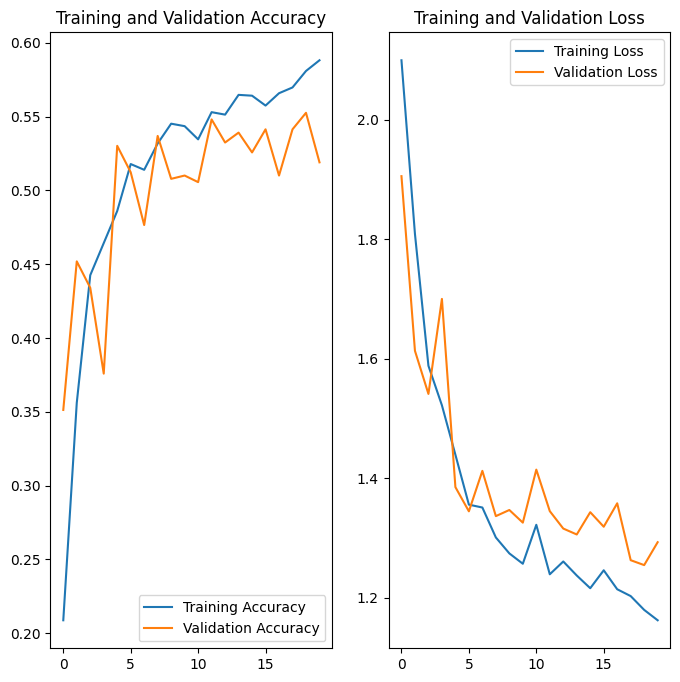

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings after Model-2 Training:-**

We'll see if there is any evidence of model overfit or underfit and if there is some improvement now as compared to the previous model run.

In the above model use of data augmentation and dropout layer reduced the problem of overfitting.

The accuracy of the model has greatly increased along with the synchronization of the validation accuracy. The loss function is synchronously exhausted for the training and validation data.

Overall, the model might be exhibiting some signs of overfitting, although not as pronounced as in the previous example.

### **Finding the distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## original_df - > path_list, lesion_list
path_list=[] # This line creates an empty list named path_list to store the paths to different images or files within our dataset.
lesion_list=[] # This line creates another empty list named lesion_list to store corresponding labels or classifications for the images or files whose paths are stored in path_list.

In [23]:
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    # For example, if i is "melanoma", it would iterate through files like data_dir_train/melanoma/melanoma_1.jpg, data_dir_train/melanoma/melanoma_2.jpg, etc.
    path_list.append(str(j)) # This line appends the full path of each found image file (j) to the path_list
    lesion_list.append(i) # This line appends the corresponding class name (i) to the lesion_list for each image.
dataframe_dict_original = dict(zip(path_list, lesion_list))
#The keys are the image paths stored in path_list. The values are the corresponding class labels stored in lesion_list.
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,vascular lesion
2235,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,vascular lesion
2236,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,vascular lesion
2237,/content/gdrive/MyDrive/Colab Notebooks/CNN_as...,vascular lesion


### **Visualizing Class Distribution:-**

<ipython-input-24-841b4936417c>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap('tab20', len(class_names))(i) for i in range(len(class_names))]


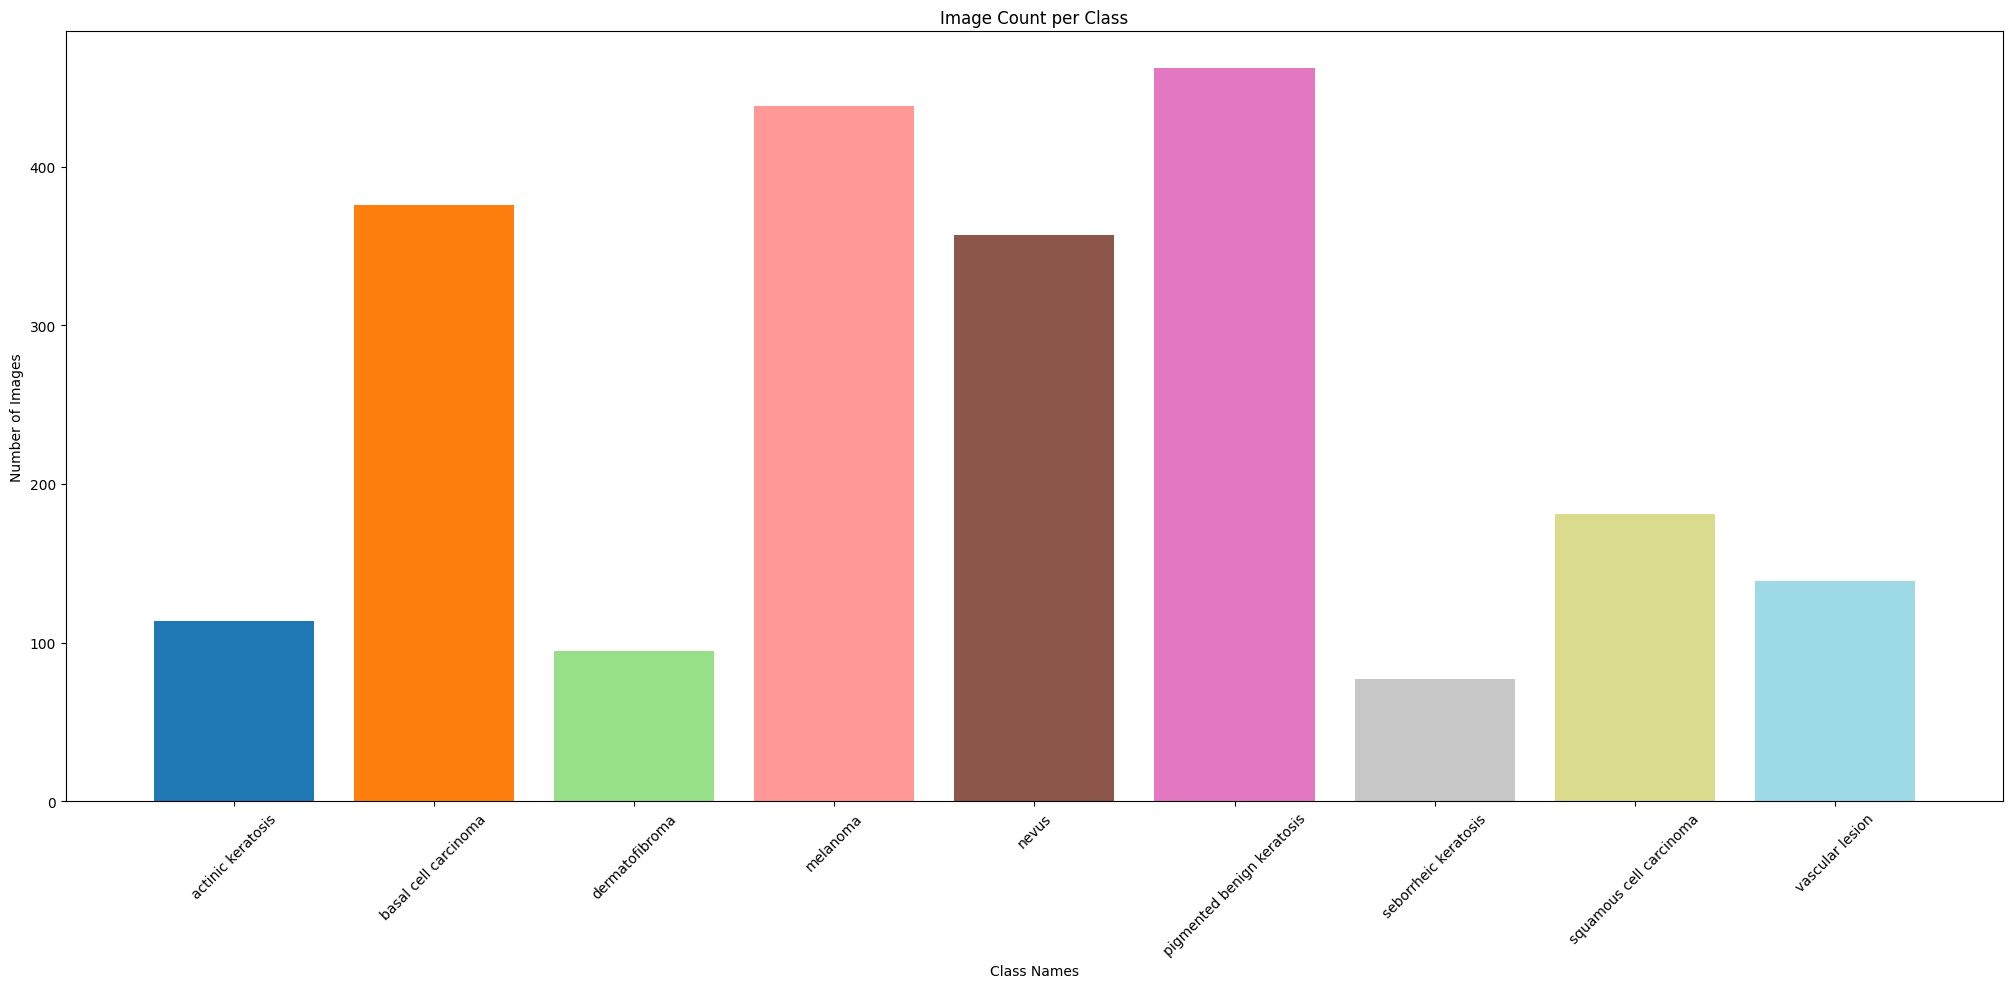

In [24]:
class_count = []  # This line creates an empty list named class_count to store the number of images for each class.

# Generate a list of random colors for each class
colors = [plt.cm.get_cmap('tab20', len(class_names))(i) for i in range(len(class_names))]

for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))

plt.figure(figsize=(25, 10))

# This line creates a bar chart to visualize the class distribution.
plt.bar(class_names, class_count, color=colors)

plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Image Count per Class')
plt.xticks(rotation=45)
plt.show()


#### **Findings from Visualizing Class Distribution:-**

#### - Which class has the least number of samples?
The least number of samples are in seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?
The classes dominate in the data are:-
* pigmented benign Keratosis
* melanoma
* basal cell carcinoma
* nevus


## **4.3 Rectify the class imbalance**
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE6764D1E90>: 100%|██████████| 500/500 [00:23<00:00, 21.44 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE676482FD0>: 100%|██████████| 500/500 [00:21<00:00, 23.78 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DE6BFFFC310>: 100%|██████████| 500/500 [00:16<00:00, 29.74 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=838x614 at 0x7DE6764D53D0>: 100%|██████████| 500/500 [01:23<00:00,  5.98 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE67652FB50>: 100%|██████████| 500/500 [01:15<00:00,  6.59 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE6763E0810>: 100%|██████████| 500/500 [00:17<00:00, 29.10 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DE67634CC10>: 100%|██████████| 500/500 [00:37<00:00, 13.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE6763B4450>: 100%|██████████| 500/500 [00:16<00:00, 29.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DE6BFF37590>: 100%|██████████| 500/500 [00:19<00:00, 26.24 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_843084df-ec20-4e95-b581-c2dfce49ca57.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_f91755ea-2f50-473f-9f50-f3e8e72f1b72.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_6965b395-798c-4d28-9495-2e07646a54ef.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment_data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_4c681403-cac9-49af-89ed-aeb971434036.jpg',
 '/content/gdrive/MyDrive/Colab 

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [32]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## **4.4 Createing Model-3**

#### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [34]:
#data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [36]:
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [38]:
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 234ms/step - accuracy: 0.2400 - loss: 3.4325 - val_accuracy: 0.1500 - val_loss: 20.1254
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.2939 - loss: 1.8129 - val_accuracy: 0.1730 - val_loss: 9.6948
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.3290 - loss: 1.7379 - val_accuracy: 0.3111 - val_loss: 2.0261
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 223ms/step - accuracy: 0.3556 - loss: 1.7040 - val_accuracy: 0.2517 - val_loss: 1.9811
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 242ms/step - accuracy: 0.3635 - loss: 1.6318 - val_accuracy: 0.3875 - val_loss: 1.7006
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.3797 - loss: 1.6256 - val_accuracy: 0.3044 - val_loss: 1.8422
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 226ms/step - accuracy: 0.3998 - loss: 1.5825 - val_accuracy: 0.4402 - val_loss: 1.4678
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 0.4330 - loss: 

#### Visualize the model results

In [39]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (1, 180, 180, 16)           │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (1, 180, 180, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (1, 90, 90, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (1, 90, 90, 32)             │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (1, 90, 90, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (1, 45, 45, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (1, 45, 45, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (1, 45, 45, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (1, 22, 22, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 22, 22, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (1, 30976)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 128)                    │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 9)                      │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,970,301 (45.66 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 7,980,052 (30.44 MB)

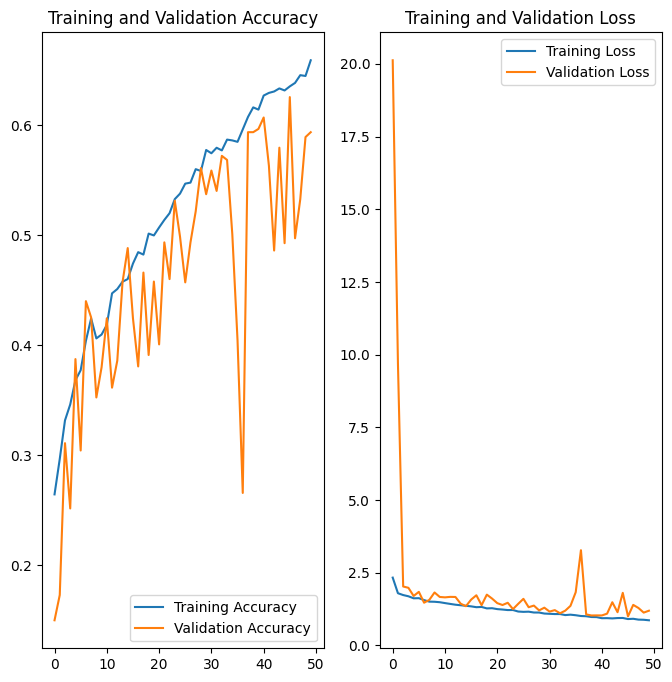

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***


1.  Implementing batch normalization in the model yielded a slight uptick in both training and validation accuracy.
2. Formulating an alternative model without batch normalization aims to investigate prospective improvements in accuracy.

## **4.5 Createing Model-4**
*Creating another model (without batch normalization)*

#### Creating another model (without batch normalization)

In [41]:
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [43]:
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - accuracy: 0.2092 - loss: 2.0716 - val_accuracy: 0.3571 - val_loss: 1.6430
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.3973 - loss: 1.5918 - val_accuracy: 0.4625 - val_loss: 1.4275
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 212ms/step - accuracy: 0.4458 - loss: 1.4660 - val_accuracy: 0.4595 - val_loss: 1.4092
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 222ms/step - accuracy: 0.4687 - loss: 1.4085 - val_accuracy: 0.4410 - val_loss: 1.4518
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 235ms/step - accuracy: 0.4897 - loss: 1.3501 - val_accuracy: 0.4967 - val_loss: 1.2835
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - accuracy: 0.4988 - loss: 1.2932 - val_accuracy: 0.4974 - val_loss: 1.3464
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 236ms/step - accuracy: 0.5088 - loss: 1.2907 - val_accuracy: 0.5219 - val_loss: 1.2626
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - accuracy: 0.5272 - loss: 1

#### Visualize the model results

In [44]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (1, 180, 180, 16)           │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (1, 90, 90, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (1, 90, 90, 32)             │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (1, 45, 45, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (1, 45, 45, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (1, 22, 22, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (1, 22, 22, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (1, 30976)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 128)                    │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 9)                      │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

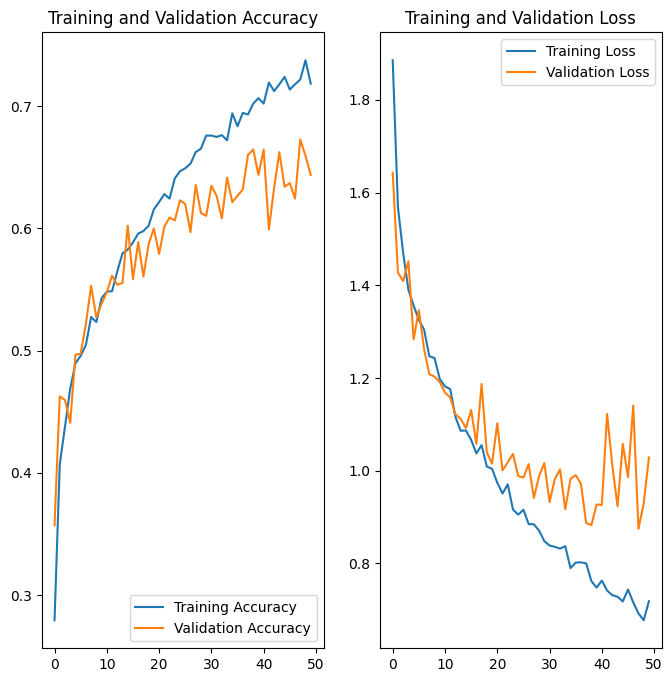

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **5. Analyze your results**



***Observations***:

1. The ultimate model showcases well-balanced performance, displaying no signs of underfitting or overfitting.

2. The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

3. Following 48 epochs, the final model attains an accuracy of 73% on the training set and approximately 67% on the validation set.

4. The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

5. The addition of batch normalization failed to enhance both training and validation accuracy.

## 6. Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


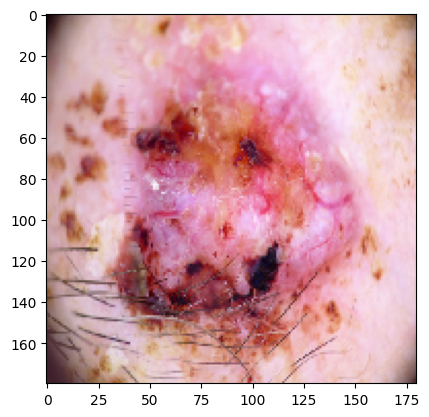

In [68]:
# Evaluating our model on one of the instances in the test set

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)